In [1]:
#Import all needed files
import csv
import sys, os, re
import time
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.signal import butter, lfilter, find_peaks

import warnings

In [2]:
#Import trial data
file_path = r"C:\Users\jgx7497\Documents\BME 390-3\Jay_Quarter2_Trial(in).csv"
df = pd.read_csv(file_path)

In [3]:
# Read the CSV into a DataFrame.
df = pd.read_csv(file_path)
    
# Define the required columns.
required_cols = ['Time(ms)', 'Acc_x(g)', 'Acc_y(g)', 'Acc_z(g)',
                 'Gyro_x', 'Gyro_y', 'Gyro_z', 'CO2(ppm)']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError("Missing required columns: " + ", ".join(missing_cols))


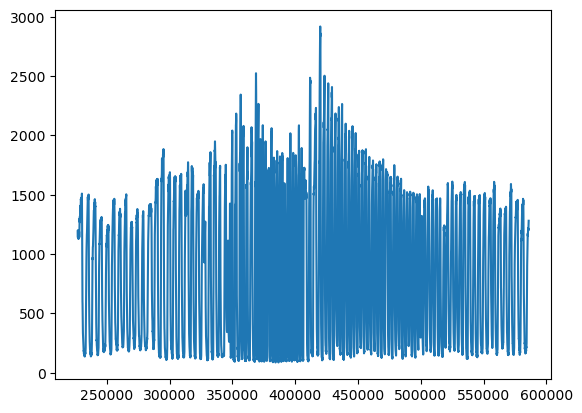

In [74]:
#Identify the accel/gyro rows and CO2 rows respectively
co2_rows = df[df['CO2(ppm)'] != 0].copy()
sensor_rows = df[(df[['Acc_x(g)', 'Acc_y(g)', 'Acc_z(g)', 'Gyro_x', 'Gyro_y', 'Gyro_z']] != 0).any(axis=1)].copy()
#Define tolerance in ms
tolerance = 5
merged_rows = []

#Prepare an empty list to collecte the merged rows
for idx, co2_row in co2_rows.iterrows():
    #Find sensor rows within +/- 3 ms
    mask = (sensor_rows["Time(ms)"] >= co2_row["Time(ms)"] - tolerance) & (sensor_rows['Time(ms)'] <= co2_row['Time(ms)'] + tolerance)
    nearby_sensors = sensor_rows[mask]

    if not nearby_sensors.empty:
        best_sensor = nearby_sensors.iloc[(nearby_sensors['Time(ms)'] - co2_row['Time(ms)']).abs().argsort()].iloc[0]
        # Merge the two rows into one
    merged_row = {
        'Time(ms)': co2_row['Time(ms)'],
        'Acc_x(g)': best_sensor['Acc_x(g)'],
        'Acc_y(g)': best_sensor['Acc_y(g)'],
        'Acc_z(g)': best_sensor['Acc_z(g)'],
        'Gyro_x': best_sensor['Gyro_x'],
        'Gyro_y': best_sensor['Gyro_y'],
        'Gyro_z': best_sensor['Gyro_z'],
        'CO2(ppm)': co2_row['CO2(ppm)']
    }
    merged_rows.append(merged_row)

merged_df = pd.DataFrame(merged_rows)

plt.figure()
plt.plot(merged_df["Time(ms)"], merged_df["CO2(ppm)"])
plt.show()

In [78]:
def give_peaks(times, signal):
    """ This helper function will find the peaks of a signal
    Args:
        times - array of time values
        signal - singal to find peaks of
    Returns:
        peak_locations - locations of peaks
        peak_values - values of peaks
    """
    peak_locations = []
    peak_values = []

    #Cast dataframes into a list
    times = list(times)
    signal = list(signal)

    #Know the distance by which to separate peaks by
    sampling_rate_hz = 20 #The SPRINTIR-WF-20 samples at 20 hz
    time_per_breath_s = 4 #assuming that the fastest someone would breathe is 4 seconds per breath
    distance_between_peaks = sampling_rate_hz * time_per_breath_s


    #Use scipy to find the peaks
    peaks, dict = find_peaks(signal, distance=100)
    for peak in peaks:
        peak_locations.append(times[peak])
        peak_values.append(signal[peak])

    return peak_locations, peak_values


In [72]:
def plot_peaks(times, signal):
    """Plots the co2 sensor signal along with the peaks"""
    #Plotting peaks of the signals
    co2_peak_locs, co2_peak_values = give_peaks(times, signal)
    plt.figure()
    plt.plot(times,signal, label="CO2 signal")
    plt.plot(co2_peak_locs, co2_peak_values, 'rx', label='Peaks')
    plt.show()
    return None

In [67]:
def find_breathing_rate(times, co2_signal):
    """Finds the breathing rate for any subset of data
    Args:
        times - array of time values
        co2_signal - array of co2 signal
    Returns:
        breathing_rate - breathing rate in bpm
    """
    peaks, values = give_peaks(times, co2_signal)
    num_breaths_total = len(peaks)
    
    #Convert from time (ms) to time (min)
    total_time_ms = times.iloc[-1] - times.iloc[0]
    total_time_minutes = total_time_ms / (1000*60)

    #Calculate and return breathing rate
    breathing_rate = num_breaths_total / total_time_minutes
    return breathing_rate